Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7154 - loss: 0.5612 - val_accuracy: 0.7285 - val_loss: 0.5166
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7978 - loss: 0.4309 - val_accuracy: 0.7377 - val_loss: 0.5327
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8054 - loss: 0.4083 - val_accuracy: 0.7413 - val_loss: 0.5220
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8210 - loss: 0.3982 - val_accuracy: 0.7541 - val_loss: 0.5021
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8204 - loss: 0.3901 - val_accuracy: 0.7370 - val_loss: 0.5209
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8285 - loss: 0.3869 - val_accuracy: 0.7356 - val_loss: 0.5146
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8327 - loss: 0.3806 - val_accuracy: 0.7370 - val_loss: 0.5219
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8322 - loss: 0.3759 - val_accu

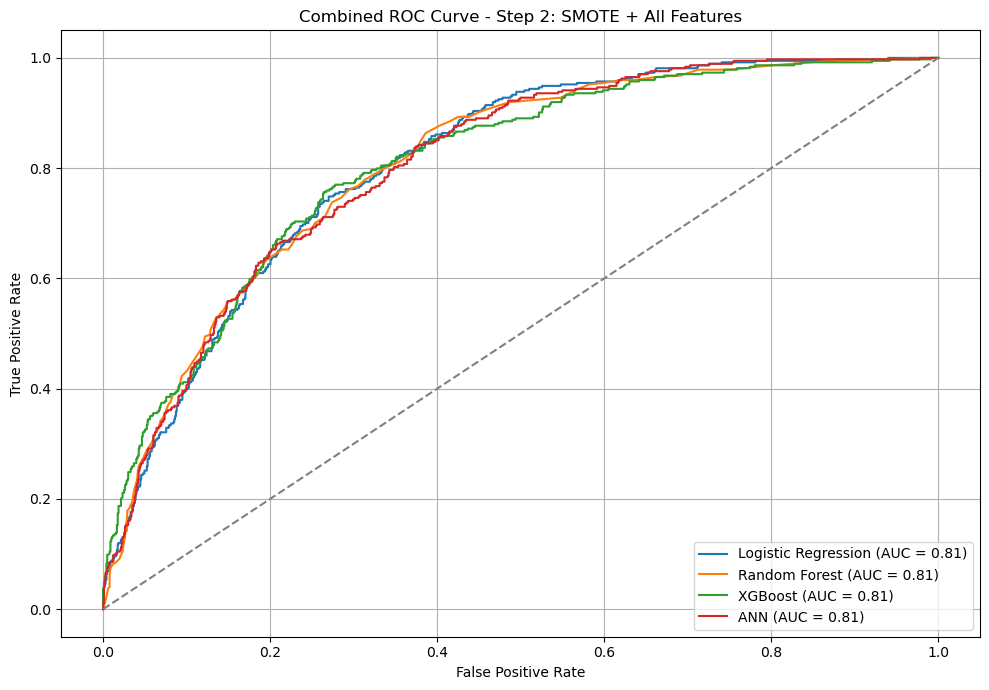

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load and preprocess
df = pd.read_csv("../data/Telecom Customers Churn.csv")
df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop("Churn", axis=1)
y = df["Churn"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE before scaling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale after SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize storage
results = []
roc_curves = {}
probabilities = {}

### 1. Logistic Regression
logreg = LogisticRegression(max_iter=2000, random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)
y_pred_lr = logreg.predict(X_test_scaled)
y_proba_lr = logreg.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_curves["Logistic Regression"] = (fpr_lr, tpr_lr)
probabilities["Logistic Regression"] = y_proba_lr

results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision (0)": precision_score(y_test, y_pred_lr, pos_label=0),
    "Recall (0)": recall_score(y_test, y_pred_lr, pos_label=0),
    "F1 (0)": f1_score(y_test, y_pred_lr, pos_label=0),
    "Precision (1)": precision_score(y_test, y_pred_lr, pos_label=1),
    "Recall (1)": recall_score(y_test, y_pred_lr, pos_label=1),
    "F1 (1)": f1_score(y_test, y_pred_lr, pos_label=1),
    "ROC AUC": roc_auc_score(y_test, y_proba_lr)
})

### 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_resampled)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_curves["Random Forest"] = (fpr_rf, tpr_rf)
probabilities["Random Forest"] = y_proba_rf

results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision (0)": precision_score(y_test, y_pred_rf, pos_label=0),
    "Recall (0)": recall_score(y_test, y_pred_rf, pos_label=0),
    "F1 (0)": f1_score(y_test, y_pred_rf, pos_label=0),
    "Precision (1)": precision_score(y_test, y_pred_rf, pos_label=1),
    "Recall (1)": recall_score(y_test, y_pred_rf, pos_label=1),
    "F1 (1)": f1_score(y_test, y_pred_rf, pos_label=1),
    "ROC AUC": roc_auc_score(y_test, y_proba_rf)
})

### 3. XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test_scaled)
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_curves["XGBoost"] = (fpr_xgb, tpr_xgb)
probabilities["XGBoost"] = y_proba_xgb

results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision (0)": precision_score(y_test, y_pred_xgb, pos_label=0),
    "Recall (0)": recall_score(y_test, y_pred_xgb, pos_label=0),
    "F1 (0)": f1_score(y_test, y_pred_xgb, pos_label=0),
    "Precision (1)": precision_score(y_test, y_pred_xgb, pos_label=1),
    "Recall (1)": recall_score(y_test, y_pred_xgb, pos_label=1),
    "F1 (1)": f1_score(y_test, y_pred_xgb, pos_label=1),
    "ROC AUC": roc_auc_score(y_test, y_proba_xgb)
})

### 4. ANN
ann = Sequential()
ann.add(Input(shape=(X_train_scaled.shape[1],)))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(16, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ann.fit(X_train_scaled, y_train_resampled,
        validation_data=(X_test_scaled, y_test),
        epochs=100, batch_size=32,
        callbacks=[early_stop], verbose=1)
y_proba_ann = ann.predict(X_test_scaled).flatten()
y_pred_ann = (y_proba_ann > 0.5).astype(int)
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_proba_ann)
roc_curves["ANN"] = (fpr_ann, tpr_ann)
probabilities["ANN"] = y_proba_ann

results.append({
    "Model": "ANN",
    "Accuracy": accuracy_score(y_test, y_pred_ann),
    "Precision (0)": precision_score(y_test, y_pred_ann, pos_label=0),
    "Recall (0)": recall_score(y_test, y_pred_ann, pos_label=0),
    "F1 (0)": f1_score(y_test, y_pred_ann, pos_label=0),
    "Precision (1)": precision_score(y_test, y_pred_ann, pos_label=1),
    "Recall (1)": recall_score(y_test, y_pred_ann, pos_label=1),
    "F1 (1)": f1_score(y_test, y_pred_ann, pos_label=1),
    "ROC AUC": roc_auc_score(y_test, y_proba_ann)
})

# Display result table
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="ROC AUC", ascending=False).reset_index(drop=True)
print("\nStep 2 - SMOTE + All Features: Model Comparison Table")
print(df_results.round(2))

# Plot ROC Curve
plt.figure(figsize=(10, 7))
for model_name, (fpr, tpr) in roc_curves.items():
    auc_score = roc_auc_score(y_test, probabilities[model_name])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curve - Step 2: SMOTE + All Features")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
